# 对用户进行聚类

数据来源于Kaggle竞赛：Event Recommendation Engine Challenge，根据
events they’ve responded to in the past
user demographic information
what events they’ve seen and clicked on in our app
用户对某个事件是否感兴趣

竞赛官网：
https://www.kaggle.com/c/event-recommendation-engine-challenge/data

由于用户众多（3w+），可以对用户进行聚类
用户描述信息在users.csv文件：共7维特征
user_id
locale：地区，语言
birthyear：出身年
gender：性别
joinedAt：用户加入APP的时间，ISO-8601 UTC time
location：地点
timezone：时区

作业要求：
根据用户的属性进行聚类（KMeans聚类）
尝试K=20， 40， 80，并计算各自CH_scores。

提示：由于样本数目较多，建议使用MiniBatchKMeans。

In [8]:
## 导入工具包
import pandas as pd
import numpy as np

#特征编码
from utils import FeatureEng

from sklearn.preprocessing import normalize
from sklearn import metrics

In [9]:
#读取数据
import pandas as pd
users= pd.read_csv("users.csv")
users.head()

user_id locale birthyear  gender                  joinedAt  \
0  3197468391  id_ID      1993    male  2012-10-02T06:40:55.524Z   
1  3537982273  id_ID      1992    male  2012-09-29T18:03:12.111Z   
2   823183725  en_US      1975    male  2012-10-06T03:14:07.149Z   
3  1872223848  en_US      1991  female  2012-11-04T08:59:43.783Z   
4  3429017717  id_ID      1995  female  2012-09-10T16:06:53.132Z   

             location  timezone  
0    Medan  Indonesia     480.0  
1    Medan  Indonesia     420.0  
2  Stratford  Ontario    -240.0  
3        Tehran  Iran     210.0  
4                 NaN     420.0

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
user_id      38209 non-null int64
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


## 缺失值填补
gender在特征编码时将缺失性别归位另一类
location 和TimezoneInt 用均值/众数填补?用0填补？

请自行补上

In [11]:
#查看类别型变量的取值情况
var = ['locale','location']
for v in var:
    print '\n%s属性的不同取值和出现的次数\n'%v
    print users[v].value_counts()


locale属性的不同取值和出现的次数

en_US    17073
id_ID    11817
es_LA     1999
en_GB     1745
es_ES      981
fa_IR      676
ar_AR      584
hu_HU      544
fr_FR      529
pt_BR      472
ka_GE      407
zh_CN      183
ru_RU      135
ja_JP      121
de_DE      119
tr_TR      109
ko_KR       91
it_IT       78
vi_VN       61
fr_CA       49
zh_TW       41
pt_PT       36
th_TH       27
km_KH       25
pl_PL       24
jv_ID       23
sv_SE       22
cs_CZ       22
el_GR       19
zh_HK       19
         ...  
bg_BG       11
hr_HR       11
nl_NL       10
he_IL        9
sk_SK        7
sr_RS        6
en_IN        5
bn_IN        4
nb_NO        4
ca_ES        4
fi_FI        4
mk_MK        4
da_DK        4
bs_BA        3
mn_MN        3
lt_LT        2
uk_UA        2
ku_TR        2
lv_LV        2
fb_LT        2
en_UD        2
af_ZA        2
az_AZ        2
hi_IN        1
cy_GB        1
pa_IN        1
eo_EO        1
et_EE        1
tl_PH        1
es_MX        1
Name: locale, Length: 64, dtype: int64

location属性的不同取值和出现的次数



locale属性有64种取值，表示了用户的语种和地区信息

In [12]:
#重置索引
#users = users.reset_index(drop=True)  
#users.head()

In [13]:
FE = FeatureEng()

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'locationId','TimezoneInt']
n_cols = len(cols)
n_users = users.shape[0]
userMatrix = np.zeros((n_users,n_cols), dtype=np.int)

for i in range(n_users): 
    userMatrix[i, 0] = FE.getLocaleId(users.loc[i,'locale'])
    userMatrix[i, 1] = FE.getBirthYearInt(users.loc[i,'birthyear'])
    userMatrix[i, 2] = FE.getGenderId(users.loc[i,'gender'])
    userMatrix[i, 3] = FE.getJoinedYearMonth(users.loc[i,'joinedAt'])
    userMatrix[i, 4] = FE.getCountryId(users['location'])
    userMatrix[i, 5] = FE.getTimezoneInt(users.loc[i,'timezone'])

FE_selected_users = pd.DataFrame(data=userMatrix, columns=cols)  

In [14]:
FE_selected_users.head()

LocaleId  BirthYearInt  GenderId  JoinedYearMonth  locationId  TimezoneInt
0       230          1993         1               34           0          480
1       230          1992         1               33           0          420
2       320          1975         1               34           0         -240
3       320          1991         2               35           0          210
4       230          1995         2               33           0          420

In [15]:
#查看类别型变量的取值情况
var = ['LocaleId','locationId']
for v in var:
    print '\n%s属性的不同取值和出现的次数\n'%v
    print FE_selected_users[v].value_counts()


LocaleId属性的不同取值和出现的次数

320    17073
230    11817
0       2627
837     1745
329      981
83       676
42       544
317      529
858      472
521      407
171      183
867      135
832      121
949      119
125      109
961       91
269       78
215       61
721       49
778       41
353       36
179       27
794       25
44        24
596       22
236       22
730       19
875       19
642       18
78        17
335       14
299       11
211       11
568       10
789        9
259        7
704        6
261        5
209        4
861        4
152        4
956        4
508        4
638        4
309        3
954        3
577        2
574        2
550        2
872        2
213        2
536        2
134        1
239        1
540        1
838        1
449        1
135        1
637        1
Name: LocaleId, dtype: int64

locationId属性的不同取值和出现的次数

0    38209
Name: locationId, dtype: int64


In [16]:
# 归一化用户矩阵
userMatrix = normalize(userMatrix, norm="l2", axis=0, copy=False)
#mmwrite("US_userMatrix", userMatrix)

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# 一个参数点（聚类数据为K）的模型，在校验集上评价聚类算法性能
def K_cluster_analysis(K, df):
    print("K-means begin with clusters: {}".format(K));
    
    #K-means,在训练集上训练
    km = MiniBatchKMeans(n_clusters = K)
    km.fit(df)
    
    #保存预测结果
    col_name = "cluster_" + str(K)
    df[col_name] = km.predict(df)

    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    #CH_score = metrics.calinski_harabaz_score(X_train,mb_kmeans.predict(X_train))
    CH_score = metrics.silhouette_score(df,df[col_name])   
    print("CH_score: {}".format(CH_score))

    return CH_score

In [ ]:
# 设置超参数（聚类数目K）搜索范围
Ks = [20,40,80]
CH_scores = []
for K in Ks:
    ch = K_cluster_analysis(K, FE_selected_users)
    CH_scores.append(ch)

K-means begin with clusters: 20
CH_score: 0.581931720821
K-means begin with clusters: 40
CH_score: 0.649487295714
K-means begin with clusters: 80


In [ ]:
FE_selected_users.to_csv('users_FE.csv')

In [ ]:
FE_selected_users.head()

In [23]:
print CH_scores

[0.58193172082067723, 0.64948729571434016, 0.74777018729923272]


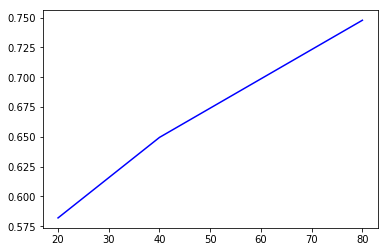

In [22]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Ks, np.array(CH_scores), 'b-')